# Load Data

In [1]:
from LoadData import outcomes_df, projects_df, donors_choose_df

In [2]:
import pandas as pd
import numpy as np
# TO DEBUG:  import pdb

In [ ]:
import CleaningFunctions as cf
import ExplorationFunctions as ef
import LoadData as ld
from Variables import *
import PipelineFunctions as pf

In [4]:
remove_from_projects = GEO_VARIABLES + ID_VARIABLES + IDX
keep_vars = [x for x in projects_df.columns if x not in remove_from_projects]
labeled_df = donors_choose_df[keep_vars + TARGET_VARIABLES]
# labeled_df['date_posted'] = pd.to_datetime(labeled_df['date_posted'])
    # with more time, would want to get temporal splits funct to work using datetime module
labeled_df = cf.change_to_1_0(labeled_df)
labeled_df = cf.impute_mean(labeled_df, given_cols=CONTINUOUS_VARIABLES)

/Users/akoko0530/Documents/GitHub/MachineLearning_CAPP30254/Homework_3/CleaningFunctions.py:53: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/akoko0530/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4355: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [5]:
#remove outliers
for var in CONTINUOUS_VARIABLES:
    labeled_df = cf.zscore_remove_outlier(labeled_df, var)
#discretize
for var in CONTINUOUS_VARIABLES:
    labeled_df = cf.discretize(labeled_df, var, 10, want_quantile=False)

In [6]:
dum_variables_of_interest = [
'poverty_level', 
'teacher_prefix',
'primary_focus_area']

In [7]:
labeled_df = cf.dummytize(labeled_df, dum_variables_of_interest)

In [8]:
features = ['school_nlns', 'school_kipp',
            'fulfillment_labor_materials',
            'teacher_teach_for_america', 'teacher_ny_teaching_fellow',
            'high poverty', 'highest poverty', 'low poverty','moderate poverty', 
            'Dr.', 'Mr.', 'Mrs.', 'Ms.', 
            'Applied Learning','Health & Sports', 'History & Civics', 
            'Literacy & Language','Math & Science', 'Music & The Arts', 'Special Needs']
target = TARGET_VARIABLES

In [9]:
labeled_df = labeled_df[features + CONTINUOUS_VARIABLES + DATE_VARIABLE + target]

In [10]:
cf.has_na(labeled_df)

[]

no rows to drop

# Simple Loop & Temporal Validation

In [11]:
from __future__ import division
from sklearn import preprocessing, cross_validation, svm, metrics, tree, decomposition, svm
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, OrthogonalMatchingPursuit, RandomizedLogisticRegression
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import ParameterGrid
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt
from scipy import optimize
import time
import seaborn as sns
%matplotlib inline

# from sklearn.metrics import precision_recall_curve


### First Temporal Split:

- Train: ('2011-01-01', '2011-12-31')
- Test: ('2012-01-01', '2012-06-31')

In [23]:
X_train, X_test, y_train, y_test = pf.create_temporal_split_dfs(labeled_df, 
                                                                features, target, 1)

x_train min: 2011-01-01 , x_train max:  2011-12-31
y_train min: 2011-01-01 , y_train max:  2011-12-31
x_test min: 2012-01-01 , x_test max:  2012-06-30
y_test min: 2012-01-01 , y_test max:  2012-06-30


In [ ]:
pf.go_function(X_train, X_test, y_train, y_test['fully_funded'])

### Second Temporal Split:

- Train: ('2011-01-01', '2012-06-31')
- Test: ('2012-07-01', '2012-12-31')

In [14]:
X_train, X_test, y_train, y_test = pf.create_temporal_split_dfs(labeled_df, 
                                                                features, target, 2)

x_train min: 2011-01-01 , x_train max:  2012-06-30
y_train min: 2011-01-01 , y_train max:  2012-06-30
x_test min: 2012-07-01 , x_test max:  2012-12-31
y_test min: 2012-07-01 , y_test max:  2012-12-31


RF


<Figure size 432x288 with 0 Axes>

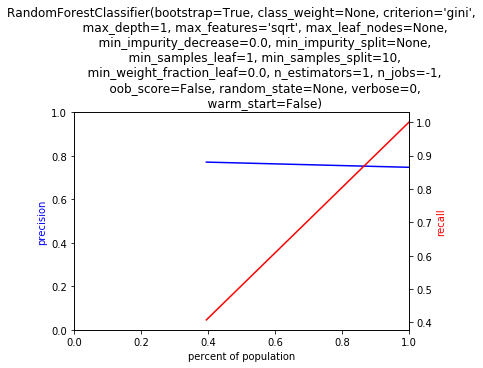

DT


<Figure size 432x288 with 0 Axes>

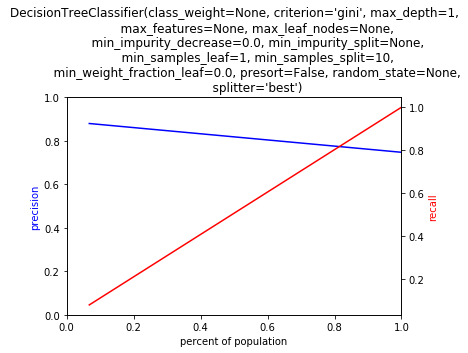

KNN


<Figure size 432x288 with 0 Axes>

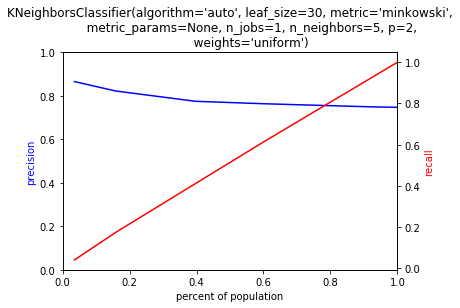

AB


<Figure size 432x288 with 0 Axes>

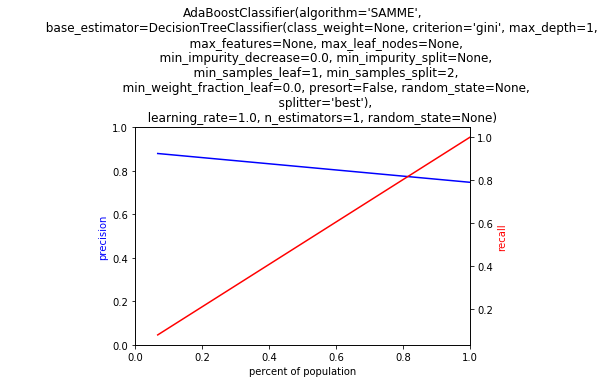

LR


<Figure size 432x288 with 0 Axes>

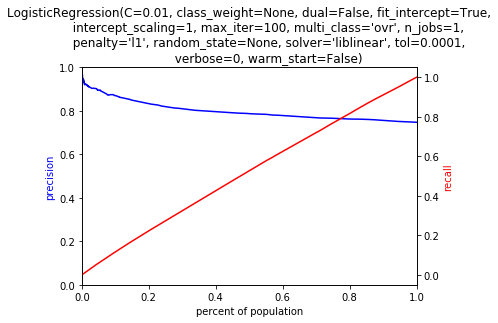

NB


<Figure size 432x288 with 0 Axes>

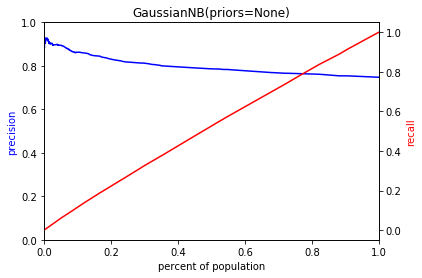

BAGGING


<Figure size 432x288 with 0 Axes>

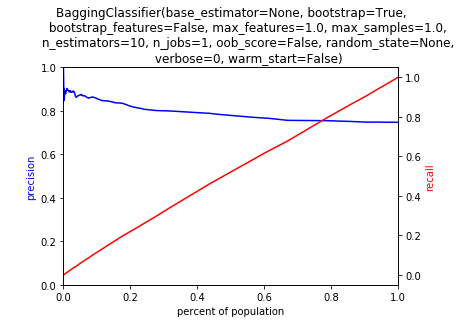

,model_type,clf,parameters,auc-roc,baseline,p_at_1,p_at_2,p_at_5,p_at_10,p_at_20,p_at_30,p_at_50,r_at_1,r_at_2,r_at_5,r_at_10,r_at_20,r_at_30,r_at_50
0,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 1, 'max_features': 'sqrt', 'min_...",0.524966,0.747365,1.000000,1.000000,1.000000,0.987821,0.548149,0.698766,0.819265,0.013362,0.026746,0.066898,0.132167,0.146681,0.280478,0.548093
1,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.523670,0.747365,1.000000,0.859464,0.837610,0.918805,0.959402,0.972935,0.983761,0.013362,0.022988,0.056035,0.122933,0.256730,0.390527,0.658142
2,KNN,"KNeighborsClassifier(algorithm='auto', leaf_si...","{'algorithm': 'auto', 'n_neighbors': 5, 'weigh...",0.541540,0.747365,0.891057,0.761982,0.904839,0.717278,0.850844,0.701743,0.821052,0.011907,0.020380,0.060532,0.095970,0.227681,0.281673,0.549288
3,AB,"(DecisionTreeClassifier(class_weight=None, cri...","{'algorithm': 'SAMME', 'n_estimators': 1}",0.523670,0.747365,1.000000,0.859464,0.837610,0.918805,0.959402,0.972935,0.983761,0.013362,0.022988,0.056035,0.122933,0.256730,0.390527,0.658142
4,LR,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'penalty': 'l1'}",0.575716,0.747365,0.921951,0.912266,0.892173,0.869601,0.825187,0.817311,0.787438,0.012319,0.024400,0.059685,0.116350,0.220815,0.328061,0.526801
5,NB,GaussianNB(priors=None),{},0.573015,0.747365,0.920325,0.903331,0.890874,0.862943,0.829652,0.814442,0.788575,0.012298,0.024161,0.059598,0.115459,0.222010,0.326909,0.527561
6,BAGGING,"(DecisionTreeClassifier(class_weight=None, cri...",{},0.553132,0.747365,0.892683,0.891145,0.870088,0.857421,0.818935,0.787648,0.800851,0.011928,0.023835,0.058207,0.114720,0.219142,0.316154,0.535774


In [15]:
pf.go_function(X_train, X_test, y_train, y_test['fully_funded'])

### Third Temporal Split:

- Train: ('2011-01-01', '2012-12-31')
- Test: ('2013-01-01', '2013-06-31')

In [16]:
X_train, X_test, y_train, y_test = pf.create_temporal_split_dfs(labeled_df, 
                                                                features, target, 3)

x_train min: 2011-01-01 , x_train max:  2012-12-31
y_train min: 2011-01-01 , y_train max:  2012-12-31
x_test min: 2013-01-01 , x_test max:  2013-06-30
y_test min: 2013-01-01 , y_test max:  2013-06-30


RF


<Figure size 432x288 with 0 Axes>

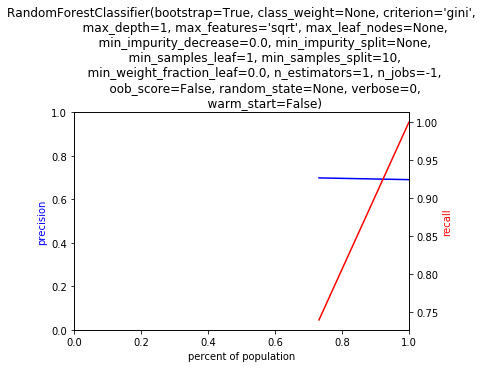

DT


<Figure size 432x288 with 0 Axes>

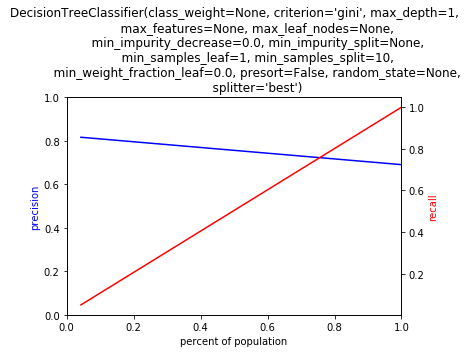

KNN


<Figure size 432x288 with 0 Axes>

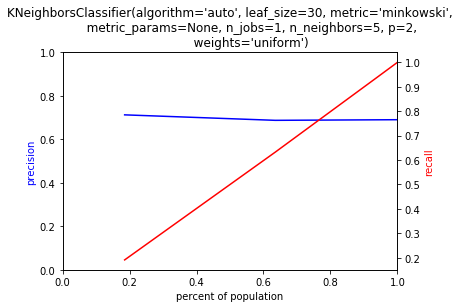

AB


<Figure size 432x288 with 0 Axes>

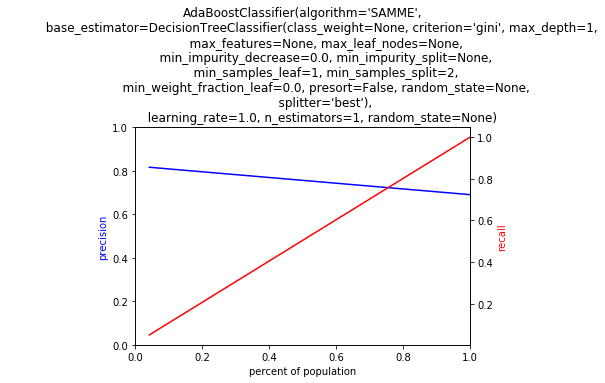

LR


<Figure size 432x288 with 0 Axes>

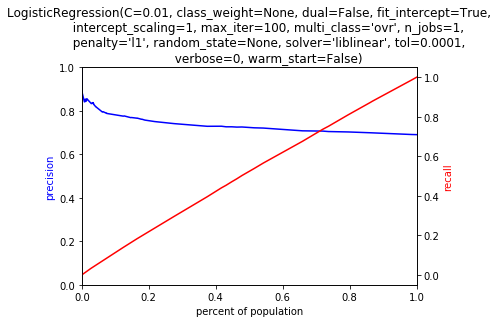

NB


<Figure size 432x288 with 0 Axes>

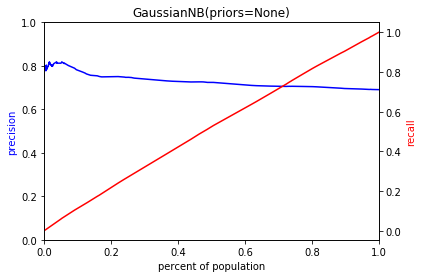

BAGGING


<Figure size 432x288 with 0 Axes>

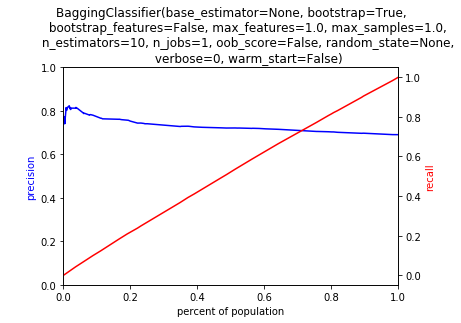

,model_type,clf,parameters,auc-roc,baseline,p_at_1,p_at_2,p_at_5,p_at_10,p_at_20,p_at_30,p_at_50,r_at_1,r_at_2,r_at_5,r_at_10,r_at_20,r_at_30,r_at_50
0,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 1, 'max_features': 'sqrt', 'min_...",0.513614,0.690593,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.014461,0.028956,0.072373,0.144782,0.289599,0.434381,0.724015
1,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.512517,0.690593,1.000000,0.667479,0.844055,0.922046,0.961028,0.974018,0.984363,0.014461,0.019328,0.061087,0.133496,0.278313,0.423095,0.712694
2,KNN,"KNeighborsClassifier(algorithm='auto', leaf_si...","{'algorithm': 'auto', 'n_neighbors': 5, 'weigh...",0.501785,0.690593,1.000000,0.710110,0.788012,0.467479,0.733772,0.789217,0.873003,0.014461,0.020562,0.057031,0.067682,0.212500,0.342821,0.632067
3,AB,"(DecisionTreeClassifier(class_weight=None, cri...","{'algorithm': 'SAMME', 'n_estimators': 1}",0.512517,0.690593,1.000000,0.667479,0.844055,0.922046,0.961028,0.974018,0.984363,0.014461,0.019328,0.061087,0.133496,0.278313,0.423095,0.712694
4,LR,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'penalty': 'l1'}",0.551552,0.690593,0.846341,0.814860,0.789474,0.721803,0.743515,0.743667,0.734119,0.012239,0.023595,0.057137,0.104504,0.215321,0.323035,0.531513
5,NB,GaussianNB(priors=None),{},0.550436,0.690593,0.800000,0.797808,0.809942,0.781486,0.724272,0.730594,0.726374,0.011568,0.023102,0.058618,0.113145,0.209749,0.317356,0.525906
6,BAGGING,"(DecisionTreeClassifier(class_weight=None, cri...",{},0.550880,0.690593,0.807317,0.811206,0.751462,0.753228,0.751675,0.684394,0.723694,0.011674,0.023490,0.054386,0.109054,0.217684,0.297288,0.523966


In [17]:
pf.go_function(X_train, X_test, y_train, y_test['fully_funded'])

### Fourth Temporal Split:

- Train: ('2011-01-01', '2013-06-31')
- Test: ('2013-07-01', '2013-12-31')

In [20]:
X_train, X_test, y_train, y_test = pf.create_temporal_split_dfs(labeled_df, 
                                                                features, target, 4)

x_train min: 2011-01-01 , x_train max:  2013-06-30
y_train min: 2011-01-01 , y_train max:  2013-06-30
x_test min: 2013-07-01 , x_test max:  2013-12-31
y_test min: 2013-07-01 , y_test max:  2013-12-31


RF


<Figure size 432x288 with 0 Axes>

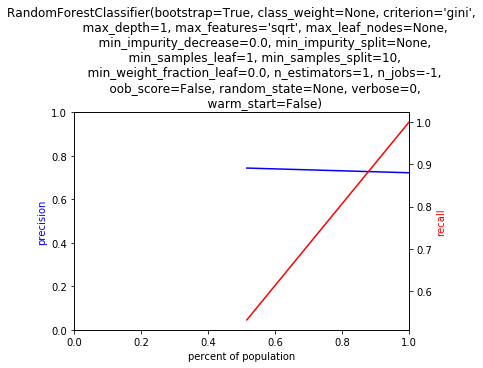

DT


<Figure size 432x288 with 0 Axes>

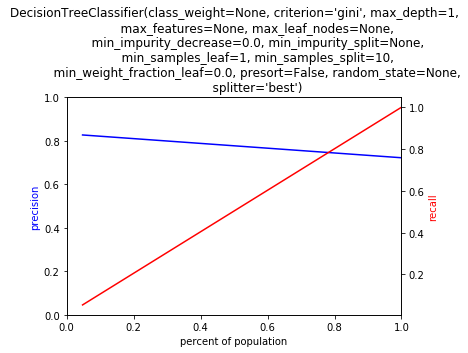

KNN


<Figure size 432x288 with 0 Axes>

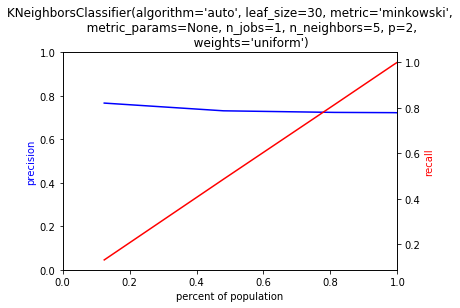

AB


<Figure size 432x288 with 0 Axes>

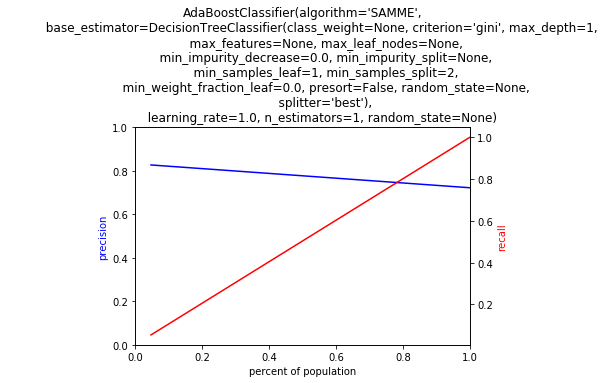

LR


<Figure size 432x288 with 0 Axes>

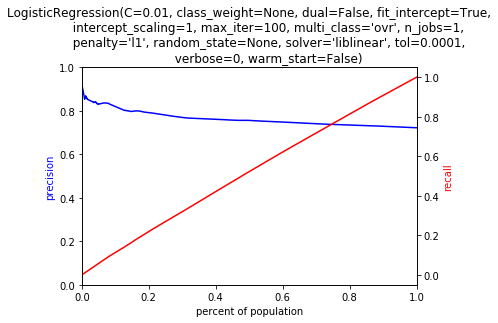

NB


<Figure size 432x288 with 0 Axes>

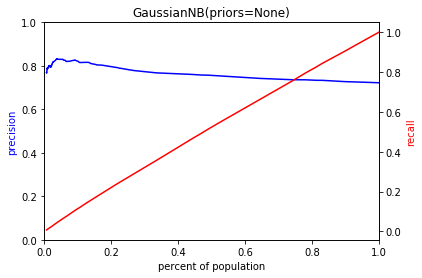

BAGGING


<Figure size 432x288 with 0 Axes>

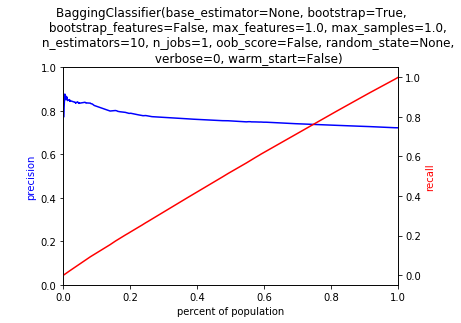

,model_type,clf,parameters,auc-roc,baseline,p_at_1,p_at_2,p_at_5,p_at_10,p_at_20,p_at_30,p_at_50,r_at_1,r_at_2,r_at_5,r_at_10,r_at_20,r_at_30,r_at_50
0,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 1, 'max_features': 'sqrt', 'min_...",0.527719,0.722269,0.998755,0.999378,0.999751,0.999876,0.625117,0.612374,0.767397,0.013813,0.027661,0.069203,0.138423,0.173094,0.254353,0.531234
1,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.512397,0.722269,1.000000,0.703174,0.835780,0.917890,0.958948,0.972632,0.983579,0.013830,0.019462,0.057853,0.127073,0.265531,0.403989,0.680887
2,KNN,"KNeighborsClassifier(algorithm='auto', leaf_si...","{'algorithm': 'auto', 'n_neighbors': 5, 'weigh...",0.515811,0.722269,1.000000,1.000000,0.622543,0.709878,0.799403,0.577500,0.741696,0.013830,0.027678,0.043093,0.098276,0.221353,0.239868,0.513443
3,AB,"(DecisionTreeClassifier(class_weight=None, cri...","{'algorithm': 'SAMME', 'n_estimators': 1}",0.512397,0.722269,1.000000,0.703174,0.835780,0.917890,0.958948,0.972632,0.983579,0.013830,0.019462,0.057853,0.127073,0.265531,0.403989,0.680887
4,LR,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'penalty': 'l1'}",0.557462,0.722269,0.850560,0.867455,0.832297,0.795098,0.775829,0.763891,0.758764,0.011763,0.024009,0.057612,0.110074,0.214826,0.317287,0.525258
5,NB,GaussianNB(priors=None),{},0.557008,0.722269,0.789539,0.795893,0.817616,0.816745,0.771164,0.765135,0.756873,0.010920,0.022029,0.056596,0.113071,0.213534,0.317804,0.523949
6,BAGGING,"(DecisionTreeClassifier(class_weight=None, cri...",{},0.555839,0.722269,0.859278,0.844431,0.842000,0.834412,0.787523,0.766794,0.753763,0.011884,0.023372,0.058284,0.115516,0.218064,0.318493,0.521796


In [21]:
pf.go_function(X_train, X_test, y_train, y_test['fully_funded'])